<a href="https://colab.research.google.com/github/jamescavanagh/unpackAI/blob/main/EEG_Alchoholism_Week_2_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

from google.colab import drive
drive.mount('/content/drive')
!pip install -Uqq fastbook kaggle waterfallcharts treeinterpreter dtreeviz mne
import fastbook
fastbook.setup_book()

Mounted at /content/drive
     |████████████████████████████████| 720 kB 15.5 MB/s 
     |████████████████████████████████| 60 kB 9.9 MB/s 
     |████████████████████████████████| 6.9 MB 56.4 MB/s 
     |████████████████████████████████| 1.2 MB 40.3 MB/s 
     |████████████████████████████████| 46 kB 5.5 MB/s 
     |████████████████████████████████| 188 kB 41.2 MB/s 
     |████████████████████████████████| 56 kB 5.4 MB/s 
     |████████████████████████████████| 51 kB 412 kB/s 
Mounted at /content/gdrive


In [ ]:
from fastbook import *
from fastai.vision.widgets import *


In [ ]:


import numpy as np
import pandas as pd 
import random
import os
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.fftpack import fft, fftfreq, rfft, rfftfreq
from sklearn.preprocessing import quantile_transform
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import normalize
from sklearn.preprocessing import scale
from sklearn.preprocessing import robust_scale
import mne
import matplotlib 
from collections import defaultdict
from math import cos, sin, acos, radians, pi
from scipy.interpolate import griddata
from numpy import newaxis
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# Imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import files
files.upload() # Upload plotting_10005.txt

#!mkdir -p ~/.kaggle
#!cp kaggle.json ~/.kaggle/ 
#!chmod 600 ~/.kaggle/kaggle.json

Saving plotting_1005.txt to plotting_1005.txt


{'plotting_1005.txt': b'LPA\t0.0000\t0.9237\t-0.3826\t\nRPA\t0.0000\t-0.9237\t-0.3826\nNz\t0.9230\t0.0000\t-0.3824\nFp1\t0.9511\t0.3090\t0.0001\nFpz\t1.0000\t-0.0000\t0.0001\nFp2\t0.9511\t-0.3091\t0.0000\nAF9\t0.7467\t0.5425\t-0.3825\nAF7\t0.8090\t0.5878\t0.0000\nAF5\t0.8553\t0.4926\t0.1552\nAF3\t0.8920\t0.3554\t0.2782\nAF1\t0.9150\t0.1857\t0.3558\nAFz\t0.9230\t0.0000\t0.3824\nAF2\t0.9150\t-0.1857\t0.3558\nAF4\t0.8919\t-0.3553\t0.2783\nAF6\t0.8553\t-0.4926\t0.1552\nAF8\t0.8090\t-0.5878\t0.0000\nAF10\t0.7467\t-0.5425\t-0.3825\nF9\t0.5430\t0.7472\t-0.3826\nF7\t0.5878\t0.8090\t0.0000\nF5\t0.6343\t0.7210\t0.2764\nF3\t0.6726\t0.5399\t0.5043\nF1\t0.6979\t0.2888\t0.6542\nFz\t0.7067\t0.0000\t0.7067\nF2\t0.6979\t-0.2888\t0.6542\nF4\t0.6726\t-0.5399\t0.5043\nF6\t0.6343\t-0.7210\t0.2764\nF8\t0.5878\t-0.8090\t0.0000\nF10\t0.5429\t-0.7472\t-0.3826\nFT9\t0.2852\t0.8777\t-0.3826\nFT7\t0.3090\t0.9511\t0.0000\nFC5\t0.3373\t0.8709\t0.3549\nFC3\t0.3612\t0.6638\t0.6545\nFC1\t0.3770\t0.3581\t0.8532\nFCz\t0

In [ ]:
#! mkdir '/home/james'
!mkdir /home/james
!mv '/content/plotting_1005.txt' '/home/james/plotting_1005.txt'

gdrivePath = '/content/drive/MyDrive/Colab_Data/EEG'
%cd '/content/drive/MyDrive/Colab_Data/EEG'

/content/drive/MyDrive/Colab_Data/EEG


In [ ]:

#downloading the dataset

#!kaggle datasets download nnair25/Alcoholics
#files.upload()
#path.ls(file_type='text')

#file_extract(os.path.join(gdrivePath,'Alchoholics.zip'))
#eegPath =  os.path.join(gdrivePath,'Alchoholics.zip')
#!unzip Alcoholics.zip

In [ ]:
filenames_list = os.listdir('SMNI_CMI_TRAIN/') ## list of file names in the directory
filenames_list = [ x for x in filenames_list if x.startswith('D')]

EEG_data = pd.DataFrame({}) ## create an empty df that will hold data from each file
EEG_data_control = pd.DataFrame({})
number = 0


for file_name in filenames_list:
    temp_df = pd.read_csv('SMNI_CMI_TRAIN/Train/' + file_name, engine = 'c') ## read from the file to df
    number += 1
    
    if 'a' in temp_df['subject identifier'].values: # For alcoholic group
                    
        EEG_data = EEG_data.append(temp_df) ## add the file data to the main df
        
        
    if 'c' in temp_df['subject identifier'].values: # For control group
                    
        EEG_data_control = EEG_data_control.append(temp_df) ## add the file data to the main df





# Cleansing the Data


In [ ]:
EEG_data = EEG_data.drop(['Unnamed: 0'], axis=1)
EEG_data.loc[EEG_data['matching condition'] == 'S2 nomatch,', 'matching condition'] =  'S2 nomatch' ## remove comma sign from stimulus name  

## replace some 'senso4/1AX4XfWjxIbaBk1mjB1EGwKxLgAcVGZ4jYKlCxUrTC3J6zb1GcEgabB3B9bMr position' values
EEG_data.loc[EEG_data['sensor position'] == 'AF1', 'sensor position'] = 'AF3'
EEG_data.loc[EEG_data['sensor position'] == 'AF2', 'sensor position'] = 'AF4'
EEG_data.loc[EEG_data['sensor position'] == 'PO1', 'sensor position'] = 'PO3'
EEG_data.loc[EEG_data['sensor position'] == 'PO2', 'sensor position'] = 'PO4'

EEG_data.loc[EEG_data['sensor position'] == 'FP1', 'sensor position'] = 'Fp1'
EEG_data.loc[EEG_data['sensor position'] == 'FP2', 'sensor position'] = 'Fp2'
EEG_data.loc[EEG_data['sensor position'] == 'CPZ', 'sensor position'] = 'CPz'
EEG_data.loc[EEG_data['sensor position'] == 'FZ', 'sensor position'] = 'Fz'

EEG_data.loc[EEG_data['sensor position'] == 'CZ', 'sensor position'] = 'Cz' ## exclusion of this position because it has a systematically extrem value

EEG_data.loc[EEG_data['sensor position'] == 'PZ', 'sensor position'] = 'Pz'
EEG_data.loc[EEG_data['sensor position'] == 'FPZ', 'sensor position'] = 'Fpz'
EEG_data.loc[EEG_data['sensor position'] == 'AFZ', 'sensor position'] = 'AFz'
EEG_data.loc[EEG_data['sensor position'] == 'FCZ', 'sensor position'] = 'FCz'

EEG_data.loc[EEG_data['sensor position'] == 'POZ', 'sensor position'] = 'POz'
EEG_data.loc[EEG_data['sensor position'] == 'OZ', 'sensor position'] = 'Oz'

In [ ]:
###same for control

EEG_data_control = EEG_data_control.drop(['Unnamed: 0'], axis=1) ## remove the unused column
EEG_data_control.loc[EEG_data_control['matching condition'] == 'S2 nomatch,', 'matching condition'] =  'S2 nomatch' ## remove comma sign from stimulus name    
## replace some 'sensor position' values
EEG_data_control.loc[EEG_data_control['sensor position'] == 'AF1', 'sensor position'] = 'AF3'
EEG_data_control.loc[EEG_data_control['sensor position'] == 'AF2', 'sensor position'] = 'AF4'
EEG_data_control.loc[EEG_data_control['sensor position'] == 'PO1', 'sensor position'] = 'PO3'
EEG_data_control.loc[EEG_data_control['sensor position'] == 'PO2', 'sensor position'] = 'PO4'

EEG_data_control.loc[EEG_data_control['sensor position'] == 'FP1', 'sensor position'] = 'Fp1'
EEG_data_control.loc[EEG_data_control['sensor position'] == 'FP2', 'sensor position'] = 'Fp2'
EEG_data_control.loc[EEG_data_control['sensor position'] == 'CPZ', 'sensor position'] = 'CPz'
EEG_data_control.loc[EEG_data_control['sensor position'] == 'FZ', 'sensor position'] = 'Fz'

EEG_data_control.loc[EEG_data_control['sensor position'] == 'CZ', 'sensor position'] = 'Cz' ## exclusion of this position because it has a systematically extrem value

EEG_data_control.loc[EEG_data_control['sensor position'] == 'PZ', 'sensor position'] = 'Pz'
EEG_data_control.loc[EEG_data_control['sensor position'] == 'FPZ', 'sensor position'] = 'Fpz'
EEG_data_control.loc[EEG_data_control['sensor position'] == 'AFZ', 'sensor position'] = 'AFz'
EEG_data_control.loc[EEG_data_control['sensor position'] == 'FCZ', 'sensor position'] = 'FCz'

EEG_data_control.loc[EEG_data_control['sensor position'] == 'POZ', 'sensor position'] = 'POz'
EEG_data_control.loc[EEG_data_control['sensor position'] == 'OZ', 'sensor position'] = 'Oz'

In [ ]:
# Checking for missing data

EEG_data_control.isnull().any()



trial number          False
sensor position       False
sample num            False
sensor value          False
subject identifier    False
matching condition    False
channel               False
name                  False
time                  False
dtype: bool

In [ ]:
EEG_data.isnull().any()

trial number          False
sensor position       False
sample num            False
sensor value          False
subject identifier    False
matching condition    False
channel               False
name                  False
time                  False
dtype: bool

In [ ]:
Alc_base = EEG_data['trial number'].unique()
Con_base = EEG_data_control['trial number'].unique()

In [ ]:
# new alc_base, Con_base
print('Number of unique trials in Alcoholics group')
print(len(Alc_base))
print('Number of unique trials in Control Group')
print((len(Con_base)))

Number of unique trials in Alcoholics group
46
Number of unique trials in Control Group
61


# Data Exploration

In [ ]:
#general content of data

EEG_data.head()

,trial number,sensor position,sample num,sensor value,subject identifier,matching condition,channel,name,time
0,15,Fp1,0,-0.773,a,S2 nomatch,0,co2a0000369,0.000000
1,15,Fp1,1,-0.773,a,S2 nomatch,0,co2a0000369,0.003906
2,15,Fp1,2,-1.750,a,S2 nomatch,0,co2a0000369,0.007812
3,15,Fp1,3,-3.215,a,S2 nomatch,0,co2a0000369,0.011719
4,15,Fp1,4,-3.703,a,S2 nomatch,0,co2a0000369,0.015625


In [ ]:
print('Number of 1 second trials in Alcoholics Group')
print(EEG_data.shape[0] / 256 / 64)

# number of seconds of EEG_data to be taken as snap shots
print('Number of 1 second trials in control Group')
print(EEG_data_control.shape[0] / 256 / 64)


Number of 1 second trials in Alcoholics Group
235.0
Number of 1 second trials in control Group
233.0


In [ ]:
# Graphical Representation of one of the signal channels
print('Number of trial participants in Alchoholics Group')
print(len(EEG_data['name'].unique()))

print('Number of trial participants in Control Group')
print(len(EEG_data_control['name'].unique()))

Number of trial participants in Alchoholics Group
8
Number of trial participants in Control Group
8


In [ ]:
print('Number of sensor positions sampling at 256htz')
print(len(EEG_data['sensor position'].unique()))

Number of sensor positions sampling at 256htz
64


In [ ]:

Trial1 = EEG_data[EEG_data['trial number'] == 2]

Trial1Subject1 = Trial1[Trial1['name'] == Trial1['name'].unique()[0]]


In [ ]:
Trial1Subject1['matching condition'].unique()

array(['S1 obj'], dtype=object)

In [ ]:
Trial1Subject1.shape[0] / 64 / 256

1.0

In [ ]:
s1Obj = Trial1Subject1[Trial1Subject1['matching condition'] == 'S1 obj']
s1Match = Trial1Subject1[Trial1Subject1['matching condition'] == 'S2 match']
s1Nomatch = Trial1Subject1[Trial1Subject1['matching condition'] == 'S2 nomatch']

In [ ]:
print('Length of s1 object in seconds')
print(s1Obj.shape[0] / 256 / 64)

print('Length of s1Match in seconds ')
print(s1Match.shape[0] / 256 / 64)

print('Length of s1 Nomatch in seconds')
print(s1Nomatch.shape[0] / 256 / 64)

Length of s1 object in seconds
1.0
Length of s1Match in seconds 
0.0
Length of s1 Nomatch in seconds
0.0


In [ ]:
trials_dic = {}
dbc = EEG_data
input_data = Alc_base


for pos in input_data:
    #print(pos)
    #print(input_data.shape)
            
    
    fullTrialData = dbc.loc[dbc['trial number'] == pos]
    
    testSubjectNameList = fullTrialData.name.unique()
    #print(f'current {pos}')
    # Total frames 16384

    #print(f'subject id list length {testSubjectNameList}')
    for nameID in testSubjectNameList:
        trial_subject  = fullTrialData.loc[fullTrialData['name'] == nameID]
    #   print(nameID)
        #print(trial_subject.shape[0])

        frameName = str(pos) + '_' + nameID              
        #trial_subject = trial_subject.pivot_table(index='channel', columns='time', values = 'sensor value')

        trials_dic[frameName] = trial_subject

print('loop done, length of trials dictionary')
#print(trials_dic.keys())

loop done, length of trials dictionary


In [ ]:
16384 / 256 / 64

1.0

# Drilling Down: Exploring an Individual Sensor Channel

In [ ]:
# All the data points on one alcoholic subject

subjectZero = EEG_data[EEG_data.name == 'co2a0000364']

In [ ]:
print('Number of data points on example subject')
print(subjectZero.shape)

Number of data points on example subject
(491520, 9)


In [ ]:
print('Number of seconds of data on the example subject')
print(subjectZero.shape[0] / 256 / 64)

Number of seconds of data on the example subject
30.0


In [ ]:
#Selecting the first trial of the first subject

subjectZeroTrialZero  = subjectZero[subjectZero['trial number'] == 0 ]

In [ ]:
# Trial Zero for subject zero
# plotting a time zeries 
oneSensor = subjectZeroTrialZero[:256] # Sensor position 7

In [ ]:
oneSensor.head()

,trial number,sensor position,sample num,sensor value,subject identifier,matching condition,channel,name,time
0,0,Fp1,0,-8.921,a,S1 obj,0,co2a0000364,0.000000
1,0,Fp1,1,-8.433,a,S1 obj,0,co2a0000364,0.003906
2,0,Fp1,2,-2.574,a,S1 obj,0,co2a0000364,0.007812
3,0,Fp1,3,5.239,a,S1 obj,0,co2a0000364,0.011719
4,0,Fp1,4,11.587,a,S1 obj,0,co2a0000364,0.015625


In [ ]:
x = oneSensor.index
y = oneSensor['sensor value']

time = oneSensor['time']
sensorValue = oneSensor['sensor value']

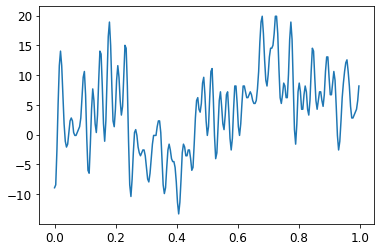

In [ ]:
# A plot of the wave over time

plt.plot(time,sensorValue)
plt.show()

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


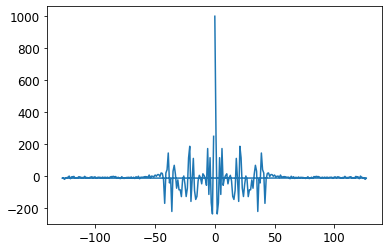

In [ ]:
from scipy.fft import fft, fftfreq

# Number of samples in normalized_tone
N = 256 * 1 # 256 htz for one second

yf = fft(sensorValue.astype(np.int64))
xf = fftfreq(N, 1 / 256)

plt.plot(xf, yf)
#fig, axes = plt.subplots(5, 5, figsize=(12, 10))
plt.show()


# Frequency Plot

### This shows the frequencies encountered over the plot. Brain waves usually operate between 0-50htz. Frequencies above 60htz are filtered out because that the electrical grid operates on that and produces noise. 

In [ ]:
import pywt
# frequency bands 1 = 0-8 hz, 2 
waveletTransform = pywt.wavedec(sensorValue,wavelet = 'db4', level=3)

# Data conversion

### The data, coming as raw time series values, needs to be converted into a wave form. This is because what we are interested in are the frequency values of brain waves. 

In [ ]:
#

In [ ]:
def eeg_to_array(inputData):
  names = inputData['name'].unique()
  index = 0
  for name in names:
    df = inputData[inputData['name'] == name]

    trials = df['trial number'].unique()
    #print(name)

    for trial in trials:
      #print(trial)
      section = df[df['trial number'] == trial]
      seconds = section[section.time == 0].shape[0]
      # break down into seconds
      index = index + seconds
  
  print(index)

    
  

In [ ]:

#lstp_Alc1 = int(round((len(Alc_base)/100)*33.33))
##lstp_Alc2 = int(round((len(Alc_base)/100)*66.66))

lstp_Alc1 = int(round((len(Alc_base)/100)*0.00))
lstp_Alc2 = int(round((len(Alc_base)/100)*95.00))

Alc_train_extractor = Alc_base #[:lstp_Alc1]
Alc_train_classifier =Alc_base#[lstp_Alc1:lstp_Alc2]
Alc_test = Alc_base[lstp_Alc2:]

#Alc_group  # ORIGINAL CODE
#lstp_Con1 = int(round((len(Con_base)/100)*33.33))
#lstp_Con2 = int(round((len(Con_base)/100)*66.66))

lstp_Con1 = int(round((len(Con_base)/100)*0.00))
lstp_Con2 = int(round((len(Con_base)/100)*95.00))


Con_train_extractor = Con_base[:lstp_Con1]
Con_train_classifier = Con_base[lstp_Con1:lstp_Con2]
Con_test = Con_base[lstp_Con2:]



In [ ]:
EEG_data['matching condition'].unique()

array(['S2 nomatch', 'S1 obj', 'S2 match'], dtype=object)

NameError: ignored

In [ ]:
# Making new groups to see differences:

# Six groups: 

#Alc_S1Obj
Alc_S1Obj = EEG_data[EEG_data['matching condition'] == 'S1 obj']

#Alc_S2Match

Alc_S2Match = EEG_data[EEG_data['matching condition'] == 'S2 match']

#Alc_S2Nomatch

Alc_S2Nomatch = EEG_data[EEG_data['matching condition'] == 'S2 nomatch']

#Con_S1Obj
Con_S1Obj = EEG_data_control[EEG_data_control['matching condition'] == 'S1 obj']

#Con_S2Match

Con_S2Match = EEG_data_control[EEG_data_control['matching condition'] == 'S2 match']

#Con_S2Nomatch

Con_S2Nomatch = EEG_data_control[EEG_data_control['matching condition'] == 'S2 nomatch']

In [ ]:
def pull_trial_numbers(input_data):
  trialNumbers = input_data['trial number'].unique()
  return trialNumbers

Alc_S1ObjTrials = pull_trial_numbers(Alc_S1Obj)
Alc_S2MatchTrials = pull_trial_numbers(Alc_S2Match)
Alc_S2NomatchTrials = pull_trial_numbers(Alc_S2Nomatch)

Con_S1ObjTrials = pull_trial_numbers(Con_S1Obj)
Con_S2MatchTrials = pull_trial_numbers(Con_S2Match)
Con_S2NomatchTrials = pull_trial_numbers(Con_S2Nomatch)




In [ ]:
Con_group = Con_base
Alc_group = Alc_base

In [ ]:
def trial_function_refactor(input_data):

    coords = pd.read_csv('/home/james/plotting_1005.txt', sep='\t',  header = None)

            #refactored to increase performance
    neeg = EEG_data.drop(columns=['matching condition','name','trial number', 'subject identifier','time', 'sample num', 'sensor value'])
        #print(neeg.shape)
    neeg = neeg.drop_duplicates()
        #print(neeg.shape)
    neeg = neeg.reset_index(drop=True)

    coords = coords.drop(coords.columns[4], axis=1)

    trials_dic = {}

    dbc = 0

    if Alc_base.shape == Con_base.shape:
        
        #print('Same shape error:')
        #print(Alc_base.shape)
        #print(Con_base.shape)
        raise SystemExit 

    if input_data.shape == Alc_base.shape[0]:
      dbc = EEG_data

    if input_data.shape == Con_base.shape[0]:
      dbc = EEG_data_control
    
    if input_data[0] == Alc_S1ObjTrials[0]:

      dbc = Alc_S1Obj

    if input_data[0] == Alc_S2MatchTrials[0]:

      dbc = Alc_S2Match

    if input_data[0] == Alc_S2NomatchTrials[0]:

      dbc = Alc_S2Nomatch
#########################
      # Control

    if input_data[0] == Con_S1ObjTrials[0]:

      dbc = Con_S1Obj

    if input_data[0] == Con_S2MatchTrials[0]:

      dbc = Con_S2Match

    if input_data[0] == Con_S2NomatchTrials[0]:

      dbc = Con_S2Nomatch


    # Removing the non condition trials if necessary


    for pos in input_data:
        #print(pos)
        #print(input_data.shape)
        #print(dbc)        
        
        fullTrialData = dbc[dbc['trial number'] == pos]

        # if filtered, drop the trials that don't fit the criterea 
        
        testSubjectNameList = fullTrialData.name.unique()
        #print(f'current {pos}')

        #print(f'subject id list length {testSubjectNameList}')
        for nameID in testSubjectNameList:
            trial_subject  = fullTrialData.loc[fullTrialData['name'] == nameID]
        #   print(nameID)

            frameName = str(pos) + '_' + nameID              
            trial_subject = trial_subject.pivot_table(index='channel', columns='time', values = 'sensor value')

            trials_dic[frameName] = trial_subject

    print('loop done, length of trials dictionary')
    print(len(trials_dic))
    #print(trials_dic.keys())



    RGB_dic = {}



    for key in trials_dic:
        #print(data.head(1))
        
        
        data = trials_dic.get(key)
        #print('starting data conversion')
        #print(data.shape)


      # if encountering the odd null value, uses a forward fill 
        #data = data.fillna(method='ffill')



        # Get real amplitudes of FFT (only in postive frequencies)

        fft_raw = fft(data)

        fft_vals = np.absolute(fft_raw)

        fft_vals = normalize(fft_vals, axis=1)

        # Get frequencies for amplitudes in Hz


        fs = 256    # Sampling rate

        fft_freq = fftfreq(fs, 1.0/fs)


        # Define EEG bands
        eeg_bands = {'Theta': (4, 7),
                  'Alpha': (8, 12),
                  'Beta': (13, 30),
                  }
        
        # Take the  sum of squared absolute values/amplitudes for each EEG band

        eeg_band_fft = defaultdict(list)

        for band in eeg_bands:  
        

            freq_ix = np.where((fft_freq >= eeg_bands[band][0]) & 
                                (fft_freq <= eeg_bands[band][1]))[0]


            
            for channel in fft_vals:
        
                filterdch = channel[freq_ix]
                
                sqdvals = np.square(filterdch)
                
                sumvals = np.sum(sqdvals, axis=0)
                
                eeg_band_fft[band].append(sumvals)
                



        extracted_df =  pd.DataFrame(eeg_band_fft)


            #refactor this to increase performance
            #neeg = EEG_data.drop(columns=['matching condition','name','trial number', 'subject identifier','time', 'sample num', 'sensor value'])
            #print(neeg.shape)
            #neeg = neeg.drop_duplicates()
            #print(neeg.shape)
            #break

            #get names of source elctrodes:

        extracted_df = extracted_df.reset_index(drop=True)
        neeg = neeg.reset_index(drop=True)



        e_names =  neeg
        e_names = e_names.rename(columns = {'sensor position' : 0})



        extracted_df = extracted_df.join(neeg)

        testerd = pd.merge(e_names, coords, on=0,  how='inner')


        testerd.set_index('channel', inplace=True)

        testerd.columns = ['pos','x', 'y', 'z']


        extracted_df = extracted_df.rename(columns={'sensor position': "pos"})

        #filter values and coordinates
        extracted_df = pd.merge(extracted_df, testerd, on="pos", how='inner')
        extracted_df = extracted_df.drop(['x','y','z'], axis=1)
        extracted_df.set_index('channel', inplace=True)

        extracted_df = extracted_df.drop(columns=['pos'])
        extracted_df.index.names = ['pos']
        #adapted from https://www.samuelbosch.com/2014/02/azimuthal-equidistant-projection.html

        class Point(object):
            def __init__(self,x, y, z):
                self.x = x
                self.y = y
                self.z = z

        class AzimuthalEquidistantProjection(object):
            """ 
                http://mathworld.wolfram.com/AzimuthalEquidistantProjection.html
                http://mathworld.wolfram.com/SphericalCoordinates.html
            """
            def __init__(self):

                self.t1 = pi / 2 ## polar latitude center of projection , https://en.wikipedia.org/wiki/Azimuthal_equidistant_projection
                self.l0 = 0 ## arbitrary longitude center of projection
                self.cost1 = cos(self.t1)
                self.sint1 = sin(self.t1)
        
            def project(self, point):
        
                #ADDAPTED FOR 3D CARTESIAN TO SPHERICAL 
        
                hxy = np.hypot(point.x, point.y)
        
                t = np.arctan2(point.z, hxy)
                l = np.arctan2(point.y, point.x)
        
                ###
        
                costcosll0 = cos(t) * cos(l-self.l0)
                sint = sin(t)
        
                c = acos ((self.sint1) * (sint) + (self.cost1) * costcosll0)
                k = c / sin(c)
        
                x = k * cos(t) * sin(l-self.l0)
                y = k * (self.cost1 * sint - self.sint1 * costcosll0)
                return x, y


            
        #Projection df

        projected_df =  pd.DataFrame()

        for index, row in testerd.iterrows():

            x = row['x']
            y = row['y']
            z = row['z']


            p = AzimuthalEquidistantProjection()
            r = p.project(Point(x,y,z))

            r = pd.Series(r)

            projected_df = projected_df.append(r,ignore_index=True)
        

        projected_df =  projected_df.rename(columns={0: 'X',1: 'Y'})


        ###map coodinate with valuies

        new_df = projected_df.join(extracted_df)
        new_df = new_df.drop([31]) # drop row because i contains no values
        #print(new_df)

        Theta_df = new_df.drop(['Alpha','Beta','X','Y'], axis=1)
        Alpha_df = new_df.drop(['Theta','Beta','X','Y'], axis=1)
        Beta_df = new_df.drop(['Theta','Alpha','X','Y'], axis=1)
        

        #map onto mesh

        xpoints = np.array(new_df[['X']].squeeze())
        ypoints = np.array(new_df[['Y']].squeeze())

        Thetavalues = np.array(Theta_df).squeeze()
        Alphavalues = np.array(Alpha_df).squeeze()
        Betavalues = np.array(Beta_df).squeeze()
        

        xx,yy = np.mgrid[-1.5:1.5:32j, -1.5:1.5:32j]

        Thetavalues = minmax_scale(Thetavalues,feature_range=(0.0, 1.0), axis=0)
        Alphavalues = minmax_scale(Alphavalues,feature_range=(0.0, 1.0), axis=0)
        Betavalues = minmax_scale(Betavalues,feature_range=(0.0, 1.0), axis=0)



        Thetagrid = griddata((xpoints, ypoints), Thetavalues, (xx, yy),method='cubic', fill_value = 0.0)
        Alphagrid = griddata((xpoints, ypoints), Alphavalues, (xx, yy),method='cubic', fill_value = 0.0)
        Betagrid = griddata((xpoints, ypoints), Betavalues, (xx, yy),method='cubic', fill_value = 0.0)
      

        ##RGB construction

        RGB = np.empty((32, 32, 3))

        RGB[:,:,0] = Thetagrid
        RGB[:,:,1] = Alphagrid
        RGB[:,:,2] = Betagrid



        RGB_dic[key] = RGB


        
    ##creating new dict with new keys

    lendict = len(RGB_dic)
    #print('lendict: ',lendict)

    lenlist=np.arange(0,lendict)

    #print(lenlist)

    final_dict = dict(zip(lenlist, list(RGB_dic.values()))) 
    return final_dict

      

In [ ]:
#test = trial_function_refactor(Con_S2NomatchTrials,trial_type = 's2 nomatch')

Alc_S1ObjTrials = pull_trial_numbers(Alc_S1Obj)
Alc_S2MatchTrials = pull_trial_numbers(Alc_S2Match)
Alc_S2NomatchTrials = pull_trial_numbers(Alc_S2Nomatch)

Con_S1ObjTrials = pull_trial_numbers(Con_S1Obj)
Con_S2MatchTrials = pull_trial_numbers(Con_S2Match)
Con_S2NomatchTrials = pull_trial_numbers(Con_S2Nomatch)



In [ ]:
EEG_data['matching condition'].unique()

array(['S2 nomatch', 'S1 obj', 'S2 match'], dtype=object)

In [ ]:
Alc_S1Obj_Dict = trial_function_refactor(Alc_S1ObjTrials)
Alc_S2Match_Dict = trial_function_refactor(Alc_S2MatchTrials)
Alc_S2Nomatch_Dict = trial_function_refactor(Alc_S2NomatchTrials)

Con_S1Obj_Dict = trial_function_refactor(Con_S1ObjTrials)
Con_S2Match_Dict = trial_function_refactor(Con_S2MatchTrials)
Con_S2Nomatch_Dict = trial_function_refactor(Con_S2NomatchTrials)

loop done, length of trials dictionary
80
loop done, length of trials dictionary
80
loop done, length of trials dictionary
75
loop done, length of trials dictionary
80
loop done, length of trials dictionary
79
loop done, length of trials dictionary
74


In [ ]:
alcTotal = 80 + 80 + 75 
conTotal = 80 + 79 + 74

!rm -rf /home/james/EEG_Image_Match_Cats

In [ ]:
def save_array_as_image(inputDict,is_alc):
 # for i, (key,value) in enumerate(inputDict.items()):
  from PIL import Image
  if is_alc == True:
     is_alc = '_alc'
  else:
     is_alc = '_con'

  for k,v in inputDict.items():
    imName = str(k) + is_alc + '.jpg'
    im = Image.fromarray((v * 255).astype(np.uint8))
    im.save(imName)

In [ ]:
# For Subgroups

# 
%mkdir /home/james
%cd /home/james/
!mkdir EEG_Images_Match_cats
%cd /home/james/EEG_Images_Match_cats


!mkdir /home/james/EEG_Images_Match_cats/Alc_S1obj
%cd /home/james/EEG_Images_Match_cats/Alc_S1obj
save_array_as_image(Alc_S1Obj_Dict,is_alc=True)

!mkdir /home/james/EEG_Images_Match_cats/Alc_S2match
%cd /home/james/EEG_Images_Match_cats/Alc_S2match
save_array_as_image(Alc_S2Match_Dict,is_alc=True)

!mkdir /home/james/EEG_Images_Match_cats/Alc_S2nomatch
%cd /home/james/EEG_Images_Match_cats/Alc_S2nomatch
save_array_as_image(Alc_S2Nomatch_Dict,is_alc=True)


!mkdir /home/james/EEG_Images_Match_cats/Con_S1obj
%cd /home/james/EEG_Images_Match_cats/Con_S1obj
save_array_as_image(Con_S1Obj_Dict,is_alc=False)

!mkdir /home/james/EEG_Images_Match_cats/Con_S2match
%cd /home/james/EEG_Images_Match_cats/Con_S2match
save_array_as_image(Con_S2Match_Dict,is_alc=False)

!mkdir /home/james/EEG_Images_Match_cats/Con_S2nomatch
%cd /home/james/EEG_Images_Match_cats/Con_S2nomatch
save_array_as_image(Con_S2Nomatch_Dict,is_alc=False)



/home/james
mkdir: cannot create directory ‘EEG_Images_Match_cats’: File exists
/home/james/EEG_Images_Match_cats
mkdir: cannot create directory ‘/home/james/EEG_Images_Match_cats/Alc_S1obj’: File exists
/home/james/EEG_Images_Match_cats/Alc_S1obj
/home/james/EEG_Images_Match_cats/Alc_S2match
/home/james/EEG_Images_Match_cats/Alc_S2nomatch
/home/james/EEG_Images_Match_cats/Con_S1obj
/home/james/EEG_Images_Match_cats/Con_S2match
/home/james/EEG_Images_Match_cats/Con_S2nomatch


In [ ]:
alc_dict = trial_function_refactor(Alc_base)

loop done, length of trials dictionary
75


In [ ]:
con_dict = trial_function_refactor(Con_base)

loop done, length of trials dictionary
80


In [ ]:
con_group = con_dict
alc_group = alc_dict

In [ ]:
# Converting and saving to images


/home/james/EEG_Images


/home/james/EEG_Images/Con
/home/james/EEG_Images/Alc


# Data Exploration and Analysis Part II



In [ ]:
%cd /home/james/

root_dir = "/home/james/EEG_Images_fft"
EEG_Con_Path = os.path.join(root_dir,'Con')
EEG_Alc_Path = os.path.join(root_dir,'Alc')

List_EEG_Con = [os.path.join(EEG_Con_Path, f) for f in os.listdir(EEG_Con_Path)]
List_EEG_Alc = [os.path.join(EEG_Alc_Path, f) for f in os.listdir(EEG_Alc_Path)]


/home/james


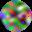

In [ ]:
Image.open(List_EEG_Alc[0])

In [ ]:
# Storing the images in a tensor
tensors_dict = {}

tensors_dict[0] = [tensor(Image.open(o)) for o in List_EEG_Con]
    
tensors_dict[1] = [tensor(Image.open(o)) for o in List_EEG_Alc]               

In [ ]:
# Creating a stacked image

stacked_tensors_dict = {}
for digit, img_tensor in tensors_dict.items():
    stacked_tensors_dict[digit] = torch.stack(img_tensor).float()/255

In [ ]:
print('Shapes of image tensor for each digit:')
for digit, img_tensor in stacked_tensors_dict.items():
    print('   ', digit, ': ', stacked_tensors_dict[digit].shape)

Shapes of image tensor for each digit:
    0 :  torch.Size([80, 32, 32, 3])
    1 :  torch.Size([75, 32, 32, 3])


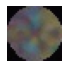

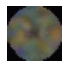

In [ ]:
means_dict = {}
for digit, tnsr in stacked_tensors_dict.items():
    means_dict[digit] = stacked_tensors_dict[digit].mean(0)
    show_image(means_dict[digit])
    # first is for alcoholics
    # Second is for the control

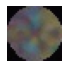

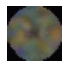

In [ ]:
# Again for each channel
# Storing the images in a tensor
tensors_dict = {}

tensors_dict[0] = [tensor(Image.open(o)) for o in List_EEG_Con]
    
tensors_dict[1] = [tensor(Image.open(o)) for o in List_EEG_Alc]  


stacked_tensors_dict = {}
for digit, img_tensor in tensors_dict.items():
    stacked_tensors_dict[digit] = torch.stack(img_tensor).float()/255


means_dict = {}
for digit, tnsr in stacked_tensors_dict.items():
    means_dict[digit] = stacked_tensors_dict[digit].mean(0)

    show_image(means_dict[digit])
    # first is for alcoholics

In [ ]:
alcTheta_mean = stacked_tensors_dict[0][:,:,:,0].mean(0)
conTheta_mean = stacked_tensors_dict[1][:,:,:,0].mean(0)

alcAlpha_mean = stacked_tensors_dict[0][:,:,:,1].mean(0)
conAlpha_mean = stacked_tensors_dict[1][:,:,:,1].mean(0)

alcBeta_mean = stacked_tensors_dict[0][:,:,:,2].mean(0)
conBeta_mean = stacked_tensors_dict[1][:,:,:,2].mean(0)

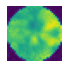

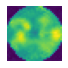

In [ ]:
show_image(alcTheta_mean)
show_image(conTheta_mean)

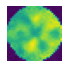

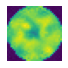

In [ ]:
show_image(alcAlpha_mean)
show_image(conAlpha_mean)

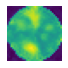

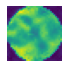

In [ ]:
show_image(alcBeta_mean)
show_image(conBeta_mean)

NameError: ignored

Suggestions for enhancing features 

# Option 1 

Amplify differences using a log approach




In [ ]:
# Now to find the key difference

In [ ]:
#dist_Alc_mae = (img - means_dict[3]).abs().mean()
#dist_3_mse = ((img - means_dict[3])**2).mean().sqrt()
#dist_3_mae, dist_3_mse

In [ ]:
alch_mean = means_dict[0] 
con_mean = means_dict[1]

print('image similarity for mean alcholic and mean control group')
totalMean = (alch_mean - con_mean).abs().mean()
print(f'total mean: {totalMean}')
print('\n')

print('Theta image similarity for mean alcholic and mean control group')
thetaMean = (alcTheta_mean - conTheta_mean).abs().mean()
print(f'total mean: {totalMean}')

print('Theta image similarity for mean alcholic and mean control group')
alphaMean = (alcAlpha_mean - conAlpha_mean).abs().mean()
print(f'total mean: {alphaMean}')

print('Theta image similarity for mean alcholic and mean control group')
betaMean = (alcBeta_mean - conBeta_mean).abs().mean()
print(f'total mean: {betaMean}')


image similarity for mean alcholic and mean control group
total mean: 0.03900657221674919


Theta image similarity for mean alcholic and mean control group
total mean: 0.03900657221674919
Theta image similarity for mean alcholic and mean control group
total mean: 0.035273633897304535
Theta image similarity for mean alcholic and mean control group
total mean: 0.04179481416940689


In [ ]:
# Different sort of processing using a wavelet transform

# Creating an image from that, and then stacking together the different regions. 



In [ ]:
sensorPositions = EEG_data['sensor position'].unique()

In [ ]:
sensorPositions

array(['Fp1', 'Fp2', 'F7', 'F8', 'AF3', 'AF4', 'Fz', 'F4', 'F3', 'FC6', 'FC5', 'FC2', 'FC1', 'T8', 'T7', 'Cz', 'C3', 'C4', 'CP5', 'CP6', 'CP1', 'CP2', 'P3', 'P4', 'Pz', 'P8', 'P7', 'PO4', 'PO3',
       'O2', 'O1', 'X', 'AF7', 'AF8', 'F5', 'F6', 'FT7', 'FT8', 'Fpz', 'FC4', 'FC3', 'C6', 'C5', 'F2', 'F1', 'TP8', 'TP7', 'AFz', 'CP3', 'CP4', 'P5', 'P6', 'C1', 'C2', 'PO7', 'PO8', 'FCz', 'POz',
       'Oz', 'P2', 'P1', 'CPz', 'nd', 'Y'], dtype=object)

In [ ]:
# sorting

#Frontal P

# Start FastAI

In [ ]:
###### Start FastAI
%cd /home/james/

root_dir = "/home/james/EEG_Images"
EEG_Con_Path = os.path.join(root_dir,'Con')
EEG_Alc_Path = os.path.join(root_dir,'Alc')

List_EEG_Con = [os.path.join(EEG_Con_Path, f) for f in os.listdir(EEG_Con_Path)]
List_EEG_Alc = [os.path.join(EEG_Alc_Path, f) for f in os.listdir(EEG_Alc_Path)]


/home/james


In [ ]:
NumOfControlImages = len(List_EEG_Con) 
NumOfAlchImages = len(List_EEG_Alc) 

print(f'Control Group size {NumOfControlImages}')
print(f'Alcholic Group size: {NumOfAlchImages}')

Control Group size 80
Alcholic Group size: 75


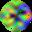

In [ ]:
from PIL import Image
picked_image = 3
im = Image.open(List_EEG_Alc[picked_image])
im.to_thumb(32,32)

# Data Exploration Part II

## Image Types



# DataLoader Step

In [ ]:
class DataLoaders(GetAttr):
  def __init__(self, *loaders): self.loaders = loaders
  def __getitem__(self, i): return self.loaders[i]
  train,valid = add_props(lambda i, self: self[i])

In [ ]:
EEGs = DataBlock (
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter = RandomSplitter(valid_pct=0.2, seed=99),
    get_y=parent_label,
    item_tfms=Resize(32,32))

In [ ]:
dls = EEGs.dataloaders
destination =Path(root_dir)
path = destination
fns = get_image_files(path)
dls = EEGs.dataloaders(path)

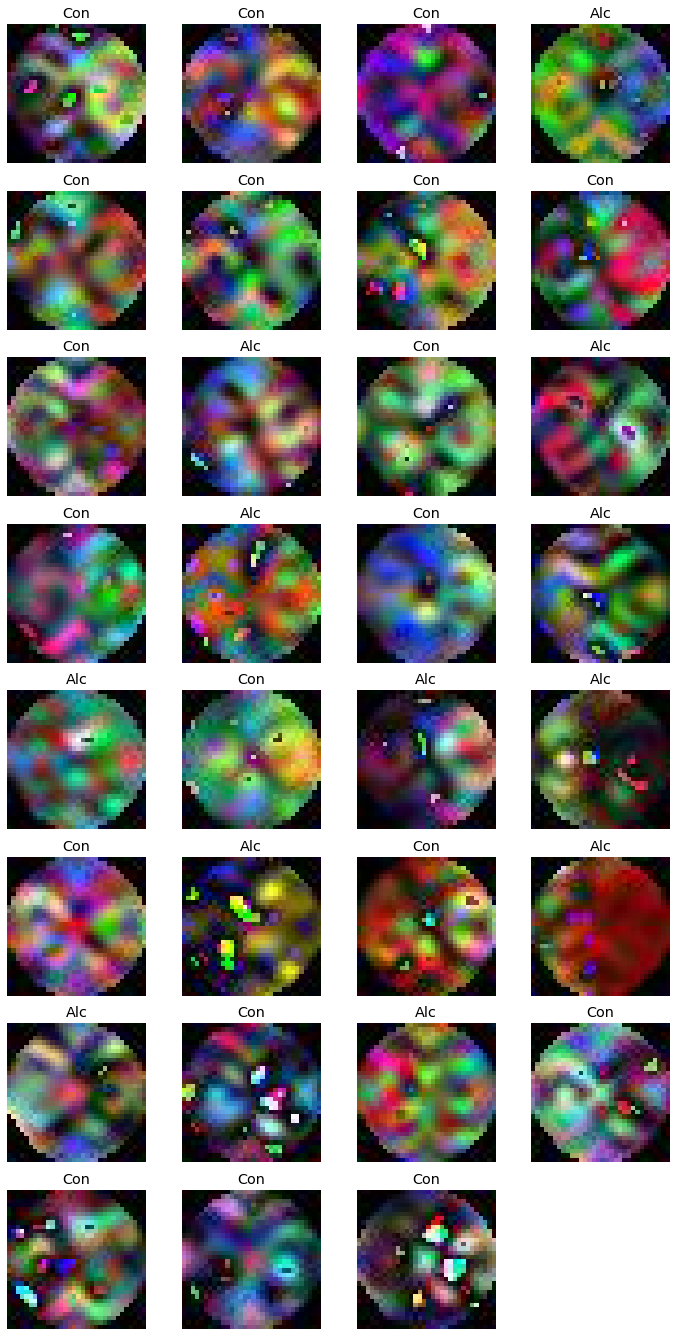

In [ ]:
dls.valid.show_batch(max_n=40, nrows=8)

In [ ]:
EEGs = EEGs.new(
    item_tfms=RandomResizedCrop(28, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = EEGs.dataloaders(path)

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1023: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  /pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:760.)
  ret = func(*args, **kwargs)


In [ ]:
EEGs = EEGs.new(
    #item_tfms=RandomResizedCrop(28, min_scale=0.5),
)
dls = EEGs.dataloaders(path)

# REsnet training

In [ ]:
# Resnet 18

learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


epoch,train_loss,valid_loss,error_rate,time
0,1.032442,0.972332,0.387097,00:00


epoch,train_loss,valid_loss,error_rate,time
0,1.080922,0.799408,0.387097,00:00
1,0.998326,0.707824,0.451613,00:00
2,0.932716,0.712771,0.387097,00:00
3,0.941755,0.726887,0.483871,00:00
4,0.899451,0.726715,0.483871,00:00


In [ ]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(10)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.459512,1.296064,0.580645,00:00


epoch,train_loss,valid_loss,error_rate,time
0,1.506086,1.386137,0.580645,00:00
1,1.356422,1.555378,0.580645,00:00
2,1.182603,1.709679,0.548387,00:00
3,1.091070,1.736831,0.548387,00:00
4,1.012407,1.815588,0.580645,00:00
5,0.921936,1.803971,0.580645,00:00
6,0.853272,1.746424,0.580645,00:00
7,0.796365,1.671170,0.580645,00:00
8,0.751194,1.617390,0.548387,00:00
9,0.713111,1.488798,0.516129,00:00


In [ ]:
# Trying squeezenet

In [ ]:
learn = cnn_learner(dls, squeezenet1_0, metrics=error_rate)
learn.fine_tune(25)

Downloading: "https://download.pytorch.org/models/squeezenet1_0-b66bff10.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_0-b66bff10.pth


  0%|          | 0.00/4.78M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.481613,2.767116,0.580645,00:00


epoch,train_loss,valid_loss,error_rate,time
0,0.968455,2.193122,0.580645,00:00
1,1.256863,1.829582,0.580645,00:00
2,1.201447,1.642308,0.548387,00:00
3,1.159639,1.399548,0.612903,00:00
4,1.114065,1.178352,0.548387,00:00
5,1.086445,1.048704,0.516129,00:00
6,1.062545,1.071923,0.483871,00:00
7,1.039069,1.062349,0.451613,00:00
8,0.999971,1.127926,0.451613,00:00
9,0.975683,1.184438,0.419355,00:00


In [ ]:
learn = cnn_learner(dls, vgg19_bn, metrics=error_rate)
learn.fine_tune(25)

Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.171461,0.792327,0.387097,00:00


epoch,train_loss,valid_loss,error_rate,time
0,1.266866,0.734852,0.387097,00:00
1,1.111792,0.697635,0.387097,00:00
2,1.010031,0.674094,0.419355,00:00
3,0.915795,0.662632,0.387097,00:00
4,0.827674,0.671129,0.451613,00:00
5,0.766559,0.696796,0.419355,00:00
6,0.720589,0.723910,0.451613,00:00
7,0.650651,0.728770,0.387097,00:00
8,0.597441,0.732459,0.387097,00:00
9,0.547936,0.730738,0.451613,00:00


In [ ]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(15)

epoch,train_loss,valid_loss,error_rate,time
0,1.054047,2.012840,0.612903,00:00


epoch,train_loss,valid_loss,error_rate,time
0,0.947099,1.952040,0.612903,00:00
1,0.927281,1.803399,0.612903,00:00
2,0.954665,1.566450,0.645161,00:00
3,0.897012,1.282635,0.580645,00:00
4,0.846970,1.105852,0.548387,00:00
5,0.773663,0.977518,0.483871,00:00
6,0.756864,0.879643,0.419355,00:00
7,0.720221,0.824027,0.354839,00:00
8,0.681439,0.783041,0.322581,00:00
9,0.645865,0.725457,0.322581,00:00


In [ ]:
learn = cnn_learner(dls, densenet121, metrics=error_rate)
learn.fine_tune(15)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.176951,1.154716,0.709677,00:00


epoch,train_loss,valid_loss,error_rate,time
0,1.253223,1.168806,0.677419,00:00
1,1.231227,1.127384,0.645161,00:00
2,1.154171,1.101569,0.645161,00:00
3,1.060613,1.174500,0.677419,00:00
4,0.981149,1.157765,0.677419,00:00
5,0.889013,1.123561,0.612903,00:00
6,0.831379,1.137380,0.612903,00:00
7,0.759401,1.152093,0.645161,00:00
8,0.712262,1.152580,0.548387,00:00
9,0.670105,1.154236,0.548387,00:00


In [ ]:
# Cross Entroy Punction

learnCrossEntropy = Learner(dls, xresnet18(n_out=dls.c), loss_func=CrossEntropyLossFlat(), 
                metrics=accuracy)
learnCrossEntropy.fit_one_cycle(8, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.853944,0.980650,0.387097,00:00
1,0.816389,1.031030,0.612903,00:00
2,0.725017,0.708411,0.612903,00:00
3,0.621560,0.942577,0.419355,00:00
4,0.563573,0.700797,0.548387,00:00
5,0.500912,0.637053,0.548387,00:00
6,0.452322,0.646885,0.612903,00:00
7,0.413924,0.666877,0.612903,00:00


In [ ]:
model = xresnet50(n_out=dls.c)
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), 
                metrics=accuracy, cbs=MixUp())
learn.fit_one_cycle(5, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.001096,1.147733,0.387097,00:00
1,0.846118,2.779218,0.612903,00:00
2,1.352616,7.824596,0.387097,00:00
3,1.772187,2.158119,0.387097,00:00
4,1.837876,2.085355,0.387097,00:00


In [ ]:
learnCrossEntropy = Learner(dls, xresnet18(n_out=dls.c), loss_func=CrossEntropyLossFlat(), 
                metrics=accuracy)
learnCrossEntropy.fine_tune(5, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.876863,1.614509,0.387097,00:00


epoch,train_loss,valid_loss,accuracy,time
0,0.836653,1.513471,0.387097,00:00
1,0.730027,1.616133,0.387097,00:00
2,0.660665,1.954228,0.387097,00:00
3,0.600054,1.859617,0.387097,00:00
4,0.536724,1.713255,0.387097,00:00


In [ ]:
interp_round1 = ClassificationInterpretation.from_learner(learn)

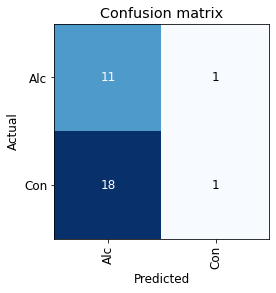

In [ ]:
interp_round1.plot_confusion_matrix()

In [ ]:
interp = ClassificationInterpretation.from_learner(learnCrossEntropy)

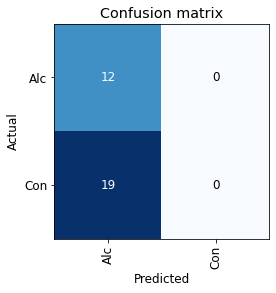

In [ ]:
interp.plot_confusion_matrix()

Analysis of Electroencephalography (EEG) signals is a standard procedure in for detection of many sorts of problems associated with brain function. EEG measures spatially located electrical activity of the brain by measuring differences of electrical potentials between electrodes located on the head. The graphical representation of electrical potential differences over time is called Electroencephalogram, and physicians use these signals or wave patterns to detect various disorders. Any detectable disorder will manifest as a deviation from the normal wave patterns, and certain medical conditions produce different types of deviations. Alongside visual evaluation of EEG signals, computer based digital signal analysis and processing techniques can also be used. Such techniques provide means for automatic, fast and reliable detection of abnormal EEG patterns, and their quantitative analysis.
The overall objective of the research project is discrimination between aggressive and non-aggressive variants of PTSP disorder. We are trying to find significant features in EEG signals that can be used to discriminate two PTSP variants and to construct a detection and discrimination algorithm. The research efforts are directed toward characteristic wave pattern analysis in time frequency domain. The primary focus is on the use of wavelet transform and its different variants. Evaluation and testing of the methods to be developed will be performed on real patient EEG signals.


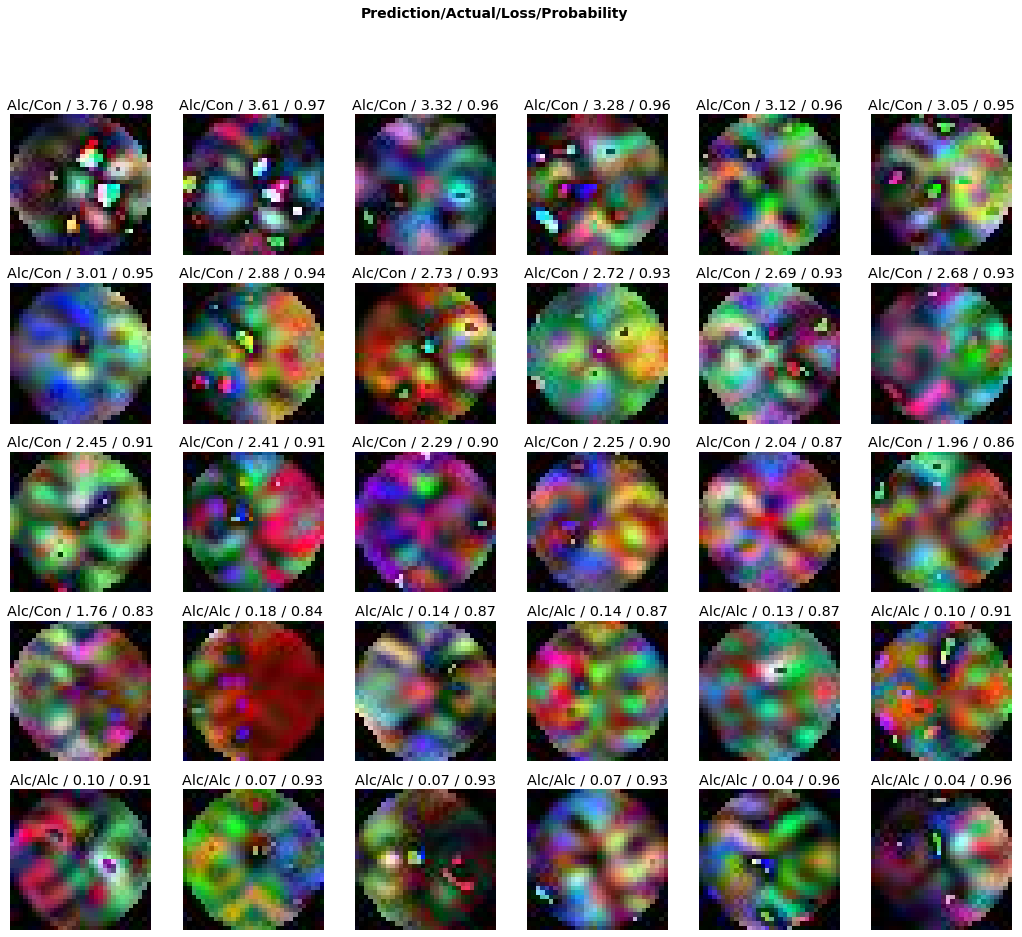

In [ ]:
interp.plot_top_losses(30)

In [ ]:
interp.print_classification_report()

              precision    recall  f1-score   support

         Alc       0.39      1.00      0.56        12
         Con       0.00      0.00      0.00        19

    accuracy                           0.39        31
   macro avg       0.19      0.50      0.28        31
weighted avg       0.15      0.39      0.22        31



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
interp.most_confused()

[('Con', 'Alc', 19)]

In [ ]:
# Mix up


model = xresnet50(n_out=dls.c)
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), 
                metrics=accuracy, cbs=MixUp())
learn.fit_one_cycle(5, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.828530,1.075128,0.387097,00:00
1,0.809332,9.041239,0.387097,00:00
2,1.430210,4.516345,0.387097,00:00
3,1.479402,6.006879,0.387097,00:00
4,1.385539,5.700757,0.387097,00:00


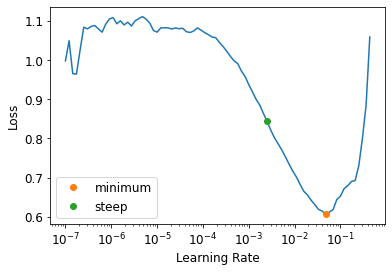

In [ ]:
# Learning Rate 
learn = cnn_learner(dls, resnet34, metrics=error_rate)
lr_min,lr_steep = learn.lr_find(suggest_funcs=(minimum, steep))

In [ ]:
%cd /home/james/EEG_Images_Match_cats/
!ls

/home/james/EEG_Images_Match_cats
Alc_S1obj  Alc_S2match	Alc_S2nomatch  Con_S1obj  Con_S2match  Con_S2nomatch


In [ ]:
###### Start FastAI Attempt 2
%cd /home/james/

root_dir = "/home/james/EEG_Images_Match_cats"


EEG_Con_S1Obj_Path = os.path.join(root_dir,'Con_S1obj')
EEG_Con_S2Match_Path = os.path.join(root_dir,'Con_S2match')
EEG_Con_S2Nomatch_Path = os.path.join(root_dir,'Con_S2nomatch')

EEG_Alc_S1Obj_Path = os.path.join(root_dir,'Alc_S1obj')
EEG_Alc_S2Match_Path = os.path.join(root_dir,'Alc_S2match')
EEG_Alc_S2Nomatch_Path = os.path.join(root_dir,'Alc_S2nomatch')

List_EEG_Con_S1Obj = [os.path.join(EEG_Con_S1Obj_Path, f) for f in os.listdir(EEG_Con_S1Obj_Path)]
List_EEG_Con_S2Match = [os.path.join(EEG_Con_S2Match_Path, f) for f in os.listdir(EEG_Con_S2Match_Path)]
List_EEG_Con_S2Nomatch = [os.path.join(EEG_Con_S2Nomatch_Path, f) for f in os.listdir(EEG_Con_S2Nomatch_Path)]

List_EEG_Alc_S1Obj = [os.path.join(EEG_Con_S1Obj_Path, f) for f in os.listdir(EEG_Con_S1Obj_Path)]
List_EEG_Alc_S2Match = [os.path.join(EEG_Con_S2Match_Path, f) for f in os.listdir(EEG_Con_S2Match_Path)]
List_EEG_Alc_S2Nomatch = [os.path.join(EEG_Con_S2Nomatch_Path, f) for f in os.listdir(EEG_Con_S2Nomatch_Path)]


List_EEG_Alc = [os.path.join(EEG_Alc_Path, f) for f in os.listdir(EEG_Alc_Path)]


/home/james


In [ ]:
class DataLoaders(GetAttr):
  def __init__(self, *loaders): self.loaders = loaders
  def __getitem__(self, i): return self.loaders[i]
  train,valid = add_props(lambda i, self: self[i])

In [ ]:
EEGs = DataBlock (
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter = RandomSplitter(valid_pct=0.2, seed=99),
    get_y=parent_label,
    item_tfms=Resize(32,32))

In [ ]:
dls = EEGs.dataloaders
destination =Path(root_dir)
path = destination
fns = get_image_files(path)
dls = EEGs.dataloaders(path)

In [ ]:
EEGs = EEGs.new(
    #item_tfms=RandomResizedCrop(28, min_scale=0.5),
)
dls = EEGs.dataloaders(path)

In [ ]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(10)

epoch,train_loss,valid_loss,error_rate,time
0,3.104719,2.403465,0.731183,00:00


epoch,train_loss,valid_loss,error_rate,time
0,2.504209,2.093601,0.731183,00:00
1,2.461131,2.076846,0.806452,00:00
2,2.308363,2.185112,0.827957,00:00
3,2.093499,2.151473,0.806452,00:00
4,1.921606,2.132269,0.774194,00:00
5,1.772542,2.144700,0.774194,00:00
6,1.621833,2.186175,0.784946,00:00
7,1.495350,2.208116,0.763441,00:00
8,1.403280,2.250231,0.774194,00:00
9,1.326374,2.279041,0.763441,00:00


In [ ]:
interp_round1 = ClassificationInterpretation.from_learner(learn)

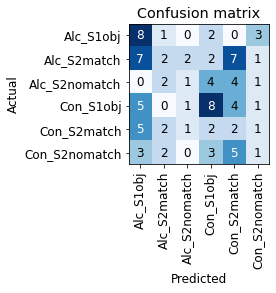

In [ ]:
interp_round1.plot_confusion_matrix()

In [ ]:
# Storing the images in a tensor
tensors_dict = {}

tensors_dict[0] = [tensor(Image.open(o)) for o in List_EEG_Con]
    
tensors_dict[1] = [tensor(Image.open(o)) for o in List_EEG_Alc]               

In [ ]:
# Creating a stacked image

stacked_tensors_dict = {}
for digit, img_tensor in tensors_dict.items():
    stacked_tensors_dict[digit] = torch.stack(img_tensor).float()/255

In [ ]:
print('Shapes of image tensor for each digit:')
for digit, img_tensor in stacked_tensors_dict.items():
    print('   ', digit, ': ', stacked_tensors_dict[digit].shape)

Shapes of image tensor for each digit:
    0 :  torch.Size([80, 32, 32, 3])
    1 :  torch.Size([75, 32, 32, 3])


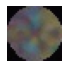

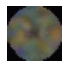

In [ ]:
means_dict = {}
for digit, tnsr in stacked_tensors_dict.items():
    means_dict[digit] = stacked_tensors_dict[digit].mean(0)
    show_image(means_dict[digit])
    # first is for alcoholics
    # Second is for the control

In [ ]:
List_EEG_Con_S1Obj = [os.path.join(EEG_Con_S1Obj_Path, f) for f in os.listdir(EEG_Con_S1Obj_Path)]
List_EEG_Con_S2Match = [os.path.join(EEG_Con_S2Match_Path, f) for f in os.listdir(EEG_Con_S2Match_Path)]
List_EEG_Con_S2Nomatch = [os.path.join(EEG_Con_S2Nomatch_Path, f) for f in os.listdir(EEG_Con_S2Nomatch_Path)]

List_EEG_Alc_S1Obj = [os.path.join(EEG_Con_S1Obj_Path, f) for f in os.listdir(EEG_Con_S1Obj_Path)]
List_EEG_Alc_S2Match = [os.path.join(EEG_Con_S2Match_Path, f) for f in os.listdir(EEG_Con_S2Match_Path)]
List_EEG_Alc_S2Nomatch = [os.path.join(EEG_Con_S2Nomatch_Path, f) for f in os.listdir(EEG_Con_S2Nomatch_Path)]

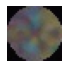

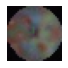

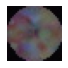

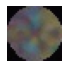

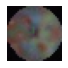

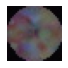

In [ ]:
# Again for each channel
# Storing the images in a tensor





tensors_dict = {}

tensors_dict[0] = [tensor(Image.open(o)) for o in List_EEG_Con_S1Obj]
tensors_dict[2] = [tensor(Image.open(o)) for o in List_EEG_Con_S2Match]
tensors_dict[4] = [tensor(Image.open(o)) for o in List_EEG_Con_S2Nomatch]

tensors_dict[1] = [tensor(Image.open(o)) for o in List_EEG_Alc_S1Obj]
tensors_dict[3] = [tensor(Image.open(o)) for o in List_EEG_Alc_S2Match]
tensors_dict[5] = [tensor(Image.open(o)) for o in List_EEG_Alc_S2Nomatch]


stacked_tensors_dict = {}
for digit, img_tensor in tensors_dict.items():
    stacked_tensors_dict[digit] = torch.stack(img_tensor).float()/255


means_dict = {}
for digit, tnsr in stacked_tensors_dict.items():
    means_dict[digit] = stacked_tensors_dict[digit].mean(0)
    show_image(means_dict[digit])

In [ ]:
alcTheta_mean = stacked_tensors_dict[0][:,:,:,0].mean(0)
conTheta_mean = stacked_tensors_dict[1][:,:,:,0].mean(0)

alcAlpha_mean = stacked_tensors_dict[0][:,:,:,1].mean(0)
conAlpha_mean = stacked_tensors_dict[1][:,:,:,1].mean(0)

alcBeta_mean = stacked_tensors_dict[0][:,:,:,2].mean(0)
conBeta_mean = stacked_tensors_dict[1][:,:,:,2].mean(0)

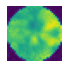

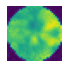

In [ ]:
show_image(alcTheta_mean)
show_image(conTheta_mean)

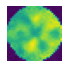

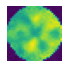

In [ ]:
show_image(alcAlpha_mean)
show_image(conAlpha_mean)

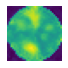

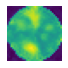

In [ ]:
show_image(alcBeta_mean)
show_image(conBeta_mean)

In [ ]:
#original thank you to _ for the code
def trialfunction(input_data):
    
    trials_dic = {}
    
    dbc = 0
    
    if Alc_train_extractor.shape == Con_train_extractor.shape:
        
        print('Same shape error:')
        print(X_train.shape)
        print(y_train.shape)
        raise SystemExit 
    
    if (input_data.shape == Alc_train_extractor.shape) or (input_data.shape == Alc_train_classifier.shape) or (input_data.shape == Alc_test.shape):
        dbc = EEG_data
        
        
    if (input_data.shape == Con_train_extractor.shape) or (input_data.shape == Con_train_classifier.shape) or (input_data.shape == Con_test.shape):
        dbc = EEG_data_control
        
    #print

    x = 0 
    for pos in input_data:               
        x = x + 1 
        Trial = dbc.loc[dbc['trial number'] == pos]
    
        columns =['channel','time', 'sensor value']
 
        Trial = Trial.pivot_table(index='channel', columns='time', values = 'sensor value')
        print(Trial.shape)
        trials_dic[pos] = Trial

    print('loop length')
    print(x)

    RGB_dic = {}
    
 

    for key in trials_dic:
        data = trials_dic.get(key)
        print('data size')
        print(data.shape)

        # Get real amplitudes of FFT (only in postive frequencies)

        fft_raw = fft(data)

        fft_vals = np.absolute(fft_raw)

        fft_vals = normalize(fft_vals, axis=1)

        # Get frequencies for amplitudes in Hz

        fs = 256    # Sampling rate

        fft_freq = fftfreq(fs, 1.0/fs)

        # Define EEG bands
        eeg_bands = {'Theta': (4, 7),
                 'Alpha': (8, 12),
                 'Beta': (13, 30),
                 }
    
        # Take the  sum of squared absolute values/amplitudes for each EEG band

        eeg_band_fft = defaultdict(list)

        for band in eeg_bands:  
        
    
            freq_ix = np.where((fft_freq >= eeg_bands[band][0]) & 
                               (fft_freq <= eeg_bands[band][1]))[0]
    

           
            for channel in fft_vals:
        
                filterdch = channel[freq_ix]
               
                sqdvals = np.square(filterdch)
               
                sumvals = np.sum(sqdvals, axis=0)
                
                eeg_band_fft[band].append(sumvals)
               



        extracted_df =  pd.DataFrame(eeg_band_fft)

    
   

        neeg = EEG_data.drop(columns=['matching condition','name','trial number', 'subject identifier','time', 'sample num', 'sensor value'])

        neeg = neeg.drop_duplicates()


        #get names of source elctrodes:

        extracted_df = extracted_df.reset_index(drop=True)
        neeg = neeg.reset_index(drop=True)



        e_names =  neeg
        e_names = e_names.rename(columns = {'sensor position' : 0})



        extracted_df = extracted_df.join(neeg)


        #get coordinates in 3d from robertoostenveld.nl/electrodes/plotting_1005.txt

        coords = pd.read_csv('/home/james/plotting_1005.txt', sep='\t',  header = None)

        coords = coords.drop(coords.columns[4], axis=1)

        #print(coords)
        testerd = pd.merge(e_names, coords, on=0,  how='inner')


        testerd.set_index('channel', inplace=True)

        testerd.columns = ['pos','x', 'y', 'z']


        extracted_df = extracted_df.rename(columns={'sensor position': "pos"})

        #filter values and coordinates
        extracted_df = pd.merge(extracted_df, testerd, on="pos", how='inner')
        extracted_df = extracted_df.drop(['x','y','z'], axis=1)
        extracted_df.set_index('channel', inplace=True)

        extracted_df = extracted_df.drop(columns=['pos'])
        extracted_df.index.names = ['pos']

      
        #adapted from https://www.samuelbosch.com/2014/02/azimuthal-equidistant-projection.html

        class Point(object):
            def __init__(self,x, y, z):
                self.x = x
                self.y = y
                self.z = z

        class AzimuthalEquidistantProjection(object):
            """ 
                http://mathworld.wolfram.com/AzimuthalEquidistantProjection.html
                http://mathworld.wolfram.com/SphericalCoordinates.html
            """
            def __init__(self):
    
                self.t1 = pi / 2 ## polar latitude center of projection , https://en.wikipedia.org/wiki/Azimuthal_equidistant_projection
                self.l0 = 0 ## arbitrary longitude center of projection
                self.cost1 = cos(self.t1)
                self.sint1 = sin(self.t1)
        
            def project(self, point):
        
                #ADDAPTED FOR 3D CARTESIAN TO SPHERICAL 
        
                hxy = np.hypot(point.x, point.y)
        
                t = np.arctan2(point.z, hxy)
                l = np.arctan2(point.y, point.x)
        
                ###
        
                costcosll0 = cos(t) * cos(l-self.l0)
                sint = sin(t)
        
                c = acos ((self.sint1) * (sint) + (self.cost1) * costcosll0)
                k = c / sin(c)
        
                x = k * cos(t) * sin(l-self.l0)
                y = k * (self.cost1 * sint - self.sint1 * costcosll0)
                return x, y


        
        #Projection df

        projected_df =  pd.DataFrame()

        for index, row in testerd.iterrows():
    
            x = row['x']
            y = row['y']
            z = row['z']
    
    
            p = AzimuthalEquidistantProjection()
            r = p.project(Point(x,y,z))
    
            r = pd.Series(r)
    
            projected_df = projected_df.append(r,ignore_index=True)
    

        projected_df =  projected_df.rename(columns={0: 'X',1: 'Y'})


        ###map coodinate with valuies

        new_df = projected_df.join(extracted_df)
        new_df = new_df.drop([31]) # drop row because i contains no values
        #print(new_df)

        Theta_df = new_df.drop(['Alpha','Beta','X','Y'], axis=1)
        Alpha_df = new_df.drop(['Theta','Beta','X','Y'], axis=1)
        Beta_df = new_df.drop(['Theta','Alpha','X','Y'], axis=1)
        

        #map onto mesh

        xpoints = np.array(new_df[['X']].squeeze())
        ypoints = np.array(new_df[['Y']].squeeze())

        Thetavalues = np.array(Theta_df).squeeze()
        Alphavalues = np.array(Alpha_df).squeeze()
        Betavalues = np.array(Beta_df).squeeze()
        

        xx,yy = np.mgrid[-1.5:1.5:32j, -1.5:1.5:32j]

        Thetavalues = minmax_scale(Thetavalues,feature_range=(0.0, 1.0), axis=0)
        Alphavalues = minmax_scale(Alphavalues,feature_range=(0.0, 1.0), axis=0)
        Betavalues = minmax_scale(Betavalues,feature_range=(0.0, 1.0), axis=0)


        Thetagrid = griddata((xpoints, ypoints), Thetavalues, (xx, yy),method='cubic', fill_value = 0.0)
        Alphagrid = griddata((xpoints, ypoints), Alphavalues, (xx, yy),method='cubic', fill_value = 0.0)
        Betagrid = griddata((xpoints, ypoints), Betavalues, (xx, yy),method='cubic', fill_value = 0.0)
     

        ##RGB construction

        RGB = np.empty((32, 32, 3))

        RGB[:,:,0] = Thetagrid
        RGB[:,:,1] = Alphagrid
        RGB[:,:,2] = Betagrid
    
    
    
        RGB_dic[key] = RGB


        
    ##creating new dict with new keys

    lendict = len(RGB_dic)
    #print('lendict: ',lendict)

    lenlist=np.arange(0,lendict)

    #print(lenlist)

    final_dict = dict(zip(lenlist, list(RGB_dic.values()))) 
    
    
    return final_dict

################ Wavelet Transform